| **Chapter**                   | 9:  Agent-based modeling                       |
| ----------------------------- |------------------------------------------------|
| **Computational Note**        | 9.23: Homesick random-destination walks        |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# Homesick random-destination walks

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
import matplotlib
import matplotlib.colors as colors
import colorcet as cc
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import pyplot as plt
import osmnx
import networkx as nx
import random
from scipy import stats
import enum

SMALL_SIZE = 5
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

colorcet  : 3.0.0
scipy     : 1.8.1
osmnx     : 1.2.0
pandas    : 1.4.2
matplotlib: 3.5.2
networkx  : 2.8.4
numpy     : 1.21.6
mesa      : 0.9.0



In [3]:
road_filter = "['highway'~'motorway|motorway_link|trunk|primary|secondary|tertiary|residential']"

In [4]:
graph = osmnx.graph_from_place("Budapest, Hungary", network_type="drive", custom_filter=road_filter)
graph = osmnx.project_graph(graph, to_crs=23700)
graph = osmnx.simplification.consolidate_intersections(graph, tolerance=50)

graph = osmnx.project_graph(graph, to_crs=4326)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:499: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subcluster_centroid = node_points.loc[wcc].unary_union.centroid
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:500: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "x"] = subcluster_centroid.x
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:501: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "y"] = subcluster_centroid.y
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:503: FutureW

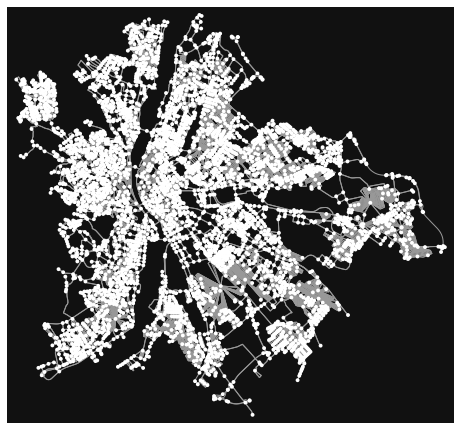

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
osmnx.plot_graph(graph)

In [6]:
class Person(Agent):
    def __init__(self, uid, model, homebase, homesickness_threshold):
        super().__init__(uid, model)
        
        self.distance_traveled = 0
        self.homebase = homebase
        self.homesickness_threshold = homesickness_threshold
        self.destination_node = None
        self.route = None

    def plot_route(self, destination):
        print(f"Plotting course from {self.pos} to {destination}.")
        route = self.model.determine_shortest_path(self.pos, destination)
        self.route = route
        route.pop(0)
        print(f"Route plotted to {destination}.")

    def move(self):
        next_node = self.route.pop(0)
        print(f"Moving to destination {next_node}.")
        self.distance_traveled += self.model.determine_distance(self.pos, next_node)
        self.pos = next_node

    def step(self):
        if self.pos == self.homebase and (self.route == None or self.destination_node == self.homebase):
            print("Agent is at home, reset distance and plot new course.")
            self.distance_traveled = 0
            self.destination_node = random.choice(list(self.model.graph.nodes.keys()))
            self.plot_route(self.destination_node)
        elif self.pos == self.destination_node:
            print("Agent is at destination.")
            self.destination_node = random.choice(list(self.model.graph.nodes.keys()))
            self.plot_route(self.destination_node)
        elif self.distance_traveled > self.homesickness_threshold and self.destination_node is not self.homebase:
            print("Agent is homesick.")
            self.plot_route(self.homebase)
            self.destination_node = self.homebase
            self.model.homesick_points.append(self.pos)
        else:
            self.move()

In [7]:
class HomesickWalkModel(Model):

    def __init__(self, homesickness_threshold=25000):
        self.graph = graph
        self.grid = NetworkGrid(self.graph)
        self.edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)

        self.schedule = RandomActivation(self)
        self.running = True

        self.homesick_points = []

        # Placing the single agent
        starting_location = random.choice(list(self.graph.nodes.keys()))
        agent = Person(uid=1234, model=self, homebase=starting_location, homesickness_threshold=homesickness_threshold)
        self.grid.place_agent(agent, starting_location)
        self.schedule.add(agent)

        self.datacollector = DataCollector(agent_reporters={"pos": "pos"})

    def determine_distance(self, node1, node2, *args) -> float:
        return self.edges.loc[(node1, node2), "length"][0]
    
    def determine_shortest_path(self, node1, node2) -> list:
        return nx.shortest_path(self.graph, node1, node2, weight=self.determine_distance, method="dijkstra")

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [8]:
model = HomesickWalkModel()

for i in range(350):
    print(f"Time: {i}")
    print(model.schedule.agents[0].pos)
    model.step()

Time: 0
2459
Agent is at home, reset distance and plot new course.
Plotting course from 2459 to 3622.


/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_14043/4189971954.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self.edges.loc[(node1, node2), "length"][0]


Route plotted to 3622.
Time: 1
2459
Moving to destination 2458.
Time: 2
2458
Moving to destination 2455.
Time: 3
2455
Moving to destination 2454.
Time: 4
2454
Moving to destination 2456.
Time: 5
2456
Moving to destination 2460.
Time: 6
2460
Moving to destination 446.
Time: 7
446
Moving to destination 2350.
Time: 8
2350
Moving to destination 563.
Time: 9
563
Moving to destination 1814.
Time: 10
1814
Moving to destination 609.
Time: 11
609
Moving to destination 610.
Time: 12
610
Moving to destination 435.
Time: 13
435
Moving to destination 960.
Time: 14
960
Moving to destination 1204.
Time: 15
1204
Moving to destination 2255.
Time: 16
2255
Moving to destination 2343.
Time: 17
2343
Moving to destination 1148.
Time: 18
1148
Moving to destination 2321.
Time: 19
2321
Moving to destination 2330.
Time: 20
2330
Moving to destination 2328.
Time: 21
2328
Moving to destination 654.
Time: 22
654
Moving to destination 2198.
Time: 23
2198
Moving to destination 2426.
Time: 24
2426
Moving to destinatio

In [9]:
agent_vars = model.datacollector.get_agent_vars_dataframe()

In [10]:
pos_list = agent_vars.reset_index()[["Step", "pos"]]

In [11]:
pos_list["v"] = pos_list.pos.shift(-1)
pos_list = pos_list.rename(columns={"pos": "u"})

In [12]:
nodes, edges = osmnx.graph_to_gdfs(graph)

In [13]:
edges_ri = edges.reset_index()

In [14]:
model.homesick_points

[17, 180, 305]

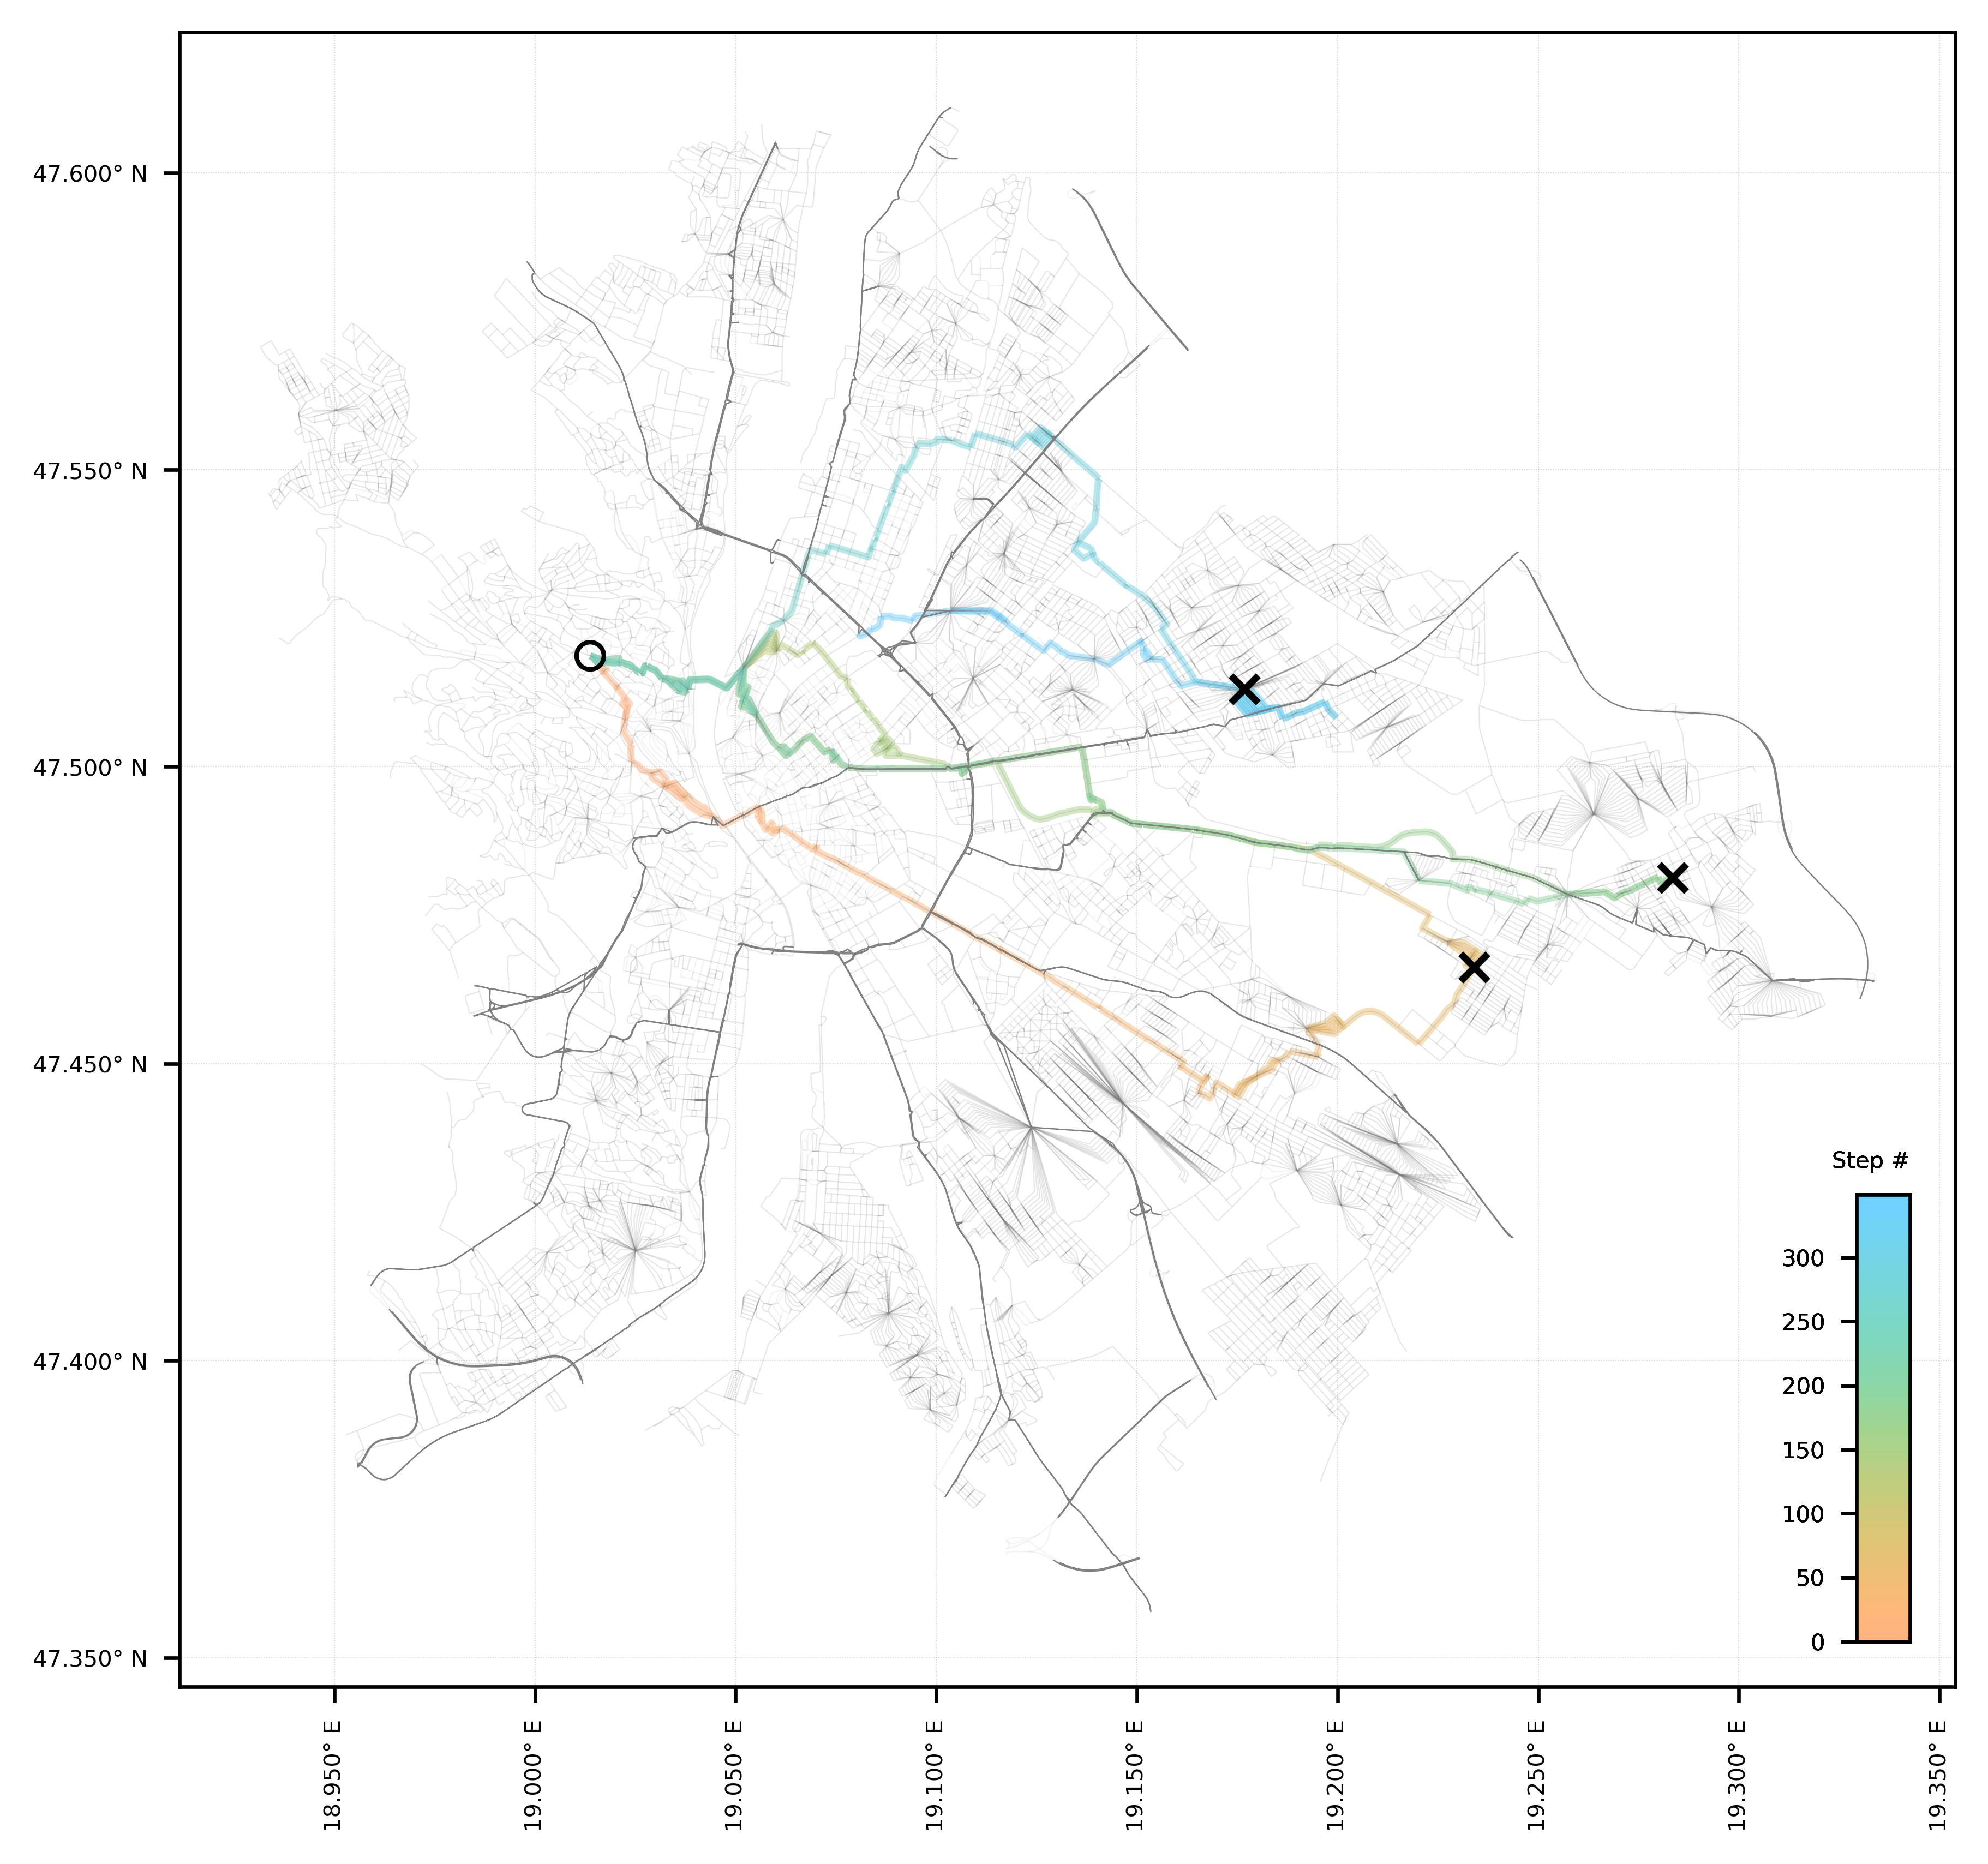

In [15]:
fig, ax = plt.subplots(1, 1, facecolor="w", figsize=(7, 7), dpi=600)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
other_roads = edges.loc[~edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]

arterial_roads.plot(ax=ax, lw=0.3, color="gray", zorder=3)
other_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.1, zorder=3)

edges_ri.merge(pos_list, on=("u", "v"), how="right", copy=True).plot("Step", ax=ax, cmap=cc.cm.isolum_r, legend=False, alpha=0.5)

ax.scatter(nodes.loc[model.schedule.agents[0].homebase, "x"], nodes.loc[model.schedule.agents[0].homebase, "y"], marker="o", facecolors="none", edgecolors="k", zorder=5)

for pt in model.homesick_points:
    ax.scatter(nodes.loc[pt, "x"], nodes.loc[pt, "y"], marker="x", color="k", zorder=4)

for sigpt in pos_list.iloc[::50].iterrows():
    if sigpt[1]["Step"] > 0:
        ux, uy = nodes.loc[sigpt[1]["u"], "x"], nodes.loc[sigpt[1]["u"], "y"]


for arrowpt in pos_list.iloc[::50].iterrows():
    if arrowpt[1]["Step"] > 0:
        plt.arrow(nodes.loc[arrowpt[1]["u"], "x"],
                  nodes.loc[arrowpt[1]["u"], "y"],
                  (nodes.loc[arrowpt[1]["v"], "x"] - nodes.loc[arrowpt[1]["u"], "x"])*1.6/10,
                  (nodes.loc[arrowpt[1]["v"], "y"] - nodes.loc[arrowpt[1]["u"], "y"])/10, lw=1, head_width=0.004, zorder=6, color="k", alpha=0.4)

    ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
    ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° E"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° N"))
    ax.grid()

    axins = inset_axes(ax, width="3%", height="27%", loc="lower right", borderpad=1)
    norm = colors.Normalize(0, edges_ri.merge(pos_list, on=("u", "v"), how="right", copy=True).Step.max())
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cc.cm.isolum_r)
    ax_cbar = fig.colorbar(cbar, cax=axins)
    axins.yaxis.set_ticks_position("left")
    axins.tick_params(axis="y", labelsize=5)
    axins.set_title("Step #", loc="right")

plt.savefig("homesick_abm.pdf")